# Generating Samples and Training

### Settings

In [1]:
import numpy as np
import strax
import straxen
import wfsim

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Histdd, Hist1d
from scipy import stats
import matplotlib.pyplot as plt

/home/zmind/anaconda3/lib/python3.7/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


In [2]:
n_photon_min = 50
n_photon_max = 350
n_electron_min = 1
n_electron_max = 5

In [3]:
st = strax.Context(
    register=wfsim.RawRecordsFromFax,
#     config=dict((detector="XENONnT"))
    **straxen.contexts.common_opts)

In [4]:
st.set_config(dict(fax_file=None))
st.set_config(dict(peak_gap_threshold=200))

In [5]:
strax.Mailbox.DEFAULT_TIMEOUT=1000000

### Generating S1 Signals

In [6]:
# Number of S1s
st.set_config(dict(nchunk=1, event_rate = 1, chunk_size = 5000))

In [7]:
# Just some id from post-SR1, so the corrections work
run_id = '180301_0302'

In [8]:
# S1 Sample Generating
dtype = wfsim.strax_interface.instruction_dtype

def rand_instructions(c):
    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    instructions = np.zeros(1 * n, dtype=dtype)
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
    instructions['t'] = np.repeat(uniform_times, 1) * int(1e9)
    instructions['event_number'] = np.digitize(instructions['t'], 
         1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1
    instructions['type'] = np.tile(['s1'], n)
    instructions['recoil'] = ['er' for i in range(n * 1)]

    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 1)
    instructions['y'] = np.repeat(r * np.sin(t), 1)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 1)

    nphotons = np.random.uniform(n_photon_min, n_photon_max, n)
    nelectrons = np.random.uniform(n_electron_min, n_electron_max, n)
    instructions['amp'] = np.vstack([nphotons]).T.flatten().astype(int)

    return instructions

wfsim.strax_interface.rand_instructions = rand_instructions
wfsim.strax_interface.instruction_dtype = dtype

In [9]:
# Remove any previously simulated data, if such exists
#!rm -r strax_data

records = st.get_array(run_id,'records')
peaks = st.get_array(run_id, ['peaks','peak_classification'])
truth = st.get_df(run_id, 'truth')
#st.waveform_display(run_id)

Simulating Raw Records: 100%|██████████| 5000/5000 [19:25<00:00,  4.31it/s]


Source finished!


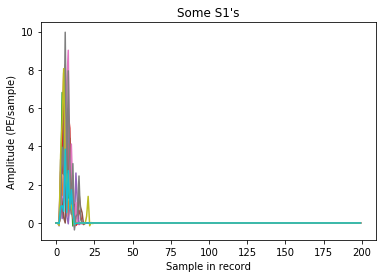

In [10]:
fig=plt.figure()
fig.patch.set_color('white')
plt.plot(peaks[peaks['type']==1]['data'][:10].T)
plt.xlabel("Sample in record")
plt.ylabel("Amplitude (PE/sample)")
plt.title("Some S1's")
plt.show()

In [11]:
# fig=plt.figure()
# fig.patch.set_color('white')
# plt.plot(peaks[peaks['type']==2]['data'][:2].T)
# plt.xlabel("Sample in record")
# plt.ylabel("Amplitude (PE/sample)")
# plt.title("Some S2's")
# plt.show()

In [12]:
print('Number of signals classified as S1: ', len(peaks[peaks['type']==1]['type']))
print('Number of signals classified as S2: ', len(peaks[peaks['type']==2]['type']))
print('All signals: ',len(peaks['type']))

Number of signals classified as S1:  4989
Number of signals classified as S2:  18
All signals:  5028


In [13]:
#peaks.dtype

In [14]:
peaks_true_s1 = peaks[abs(peaks['time']%(5e+8)-5e+8)<600]
len(peaks_true_s1)

4997

In [15]:
# fig=plt.figure()
# fig.patch.set_color('white')
# plt.hist(peaks_true_s1['area'],bins=50,range=(0,200),histtype='step')
# plt.xlabel('size [PE]')
# plt.ylabel('Counts')
# plt.title('S1 distribution')
# plt.show()

### Generating S2 Signals

In [16]:
# Number of S2s
st.set_config(dict(nchunk=1, event_rate = 1, chunk_size = 5000))

In [17]:
# Just some id from post-SR1, so the corrections work
run_id = '180302_0303'

In [18]:
# S2 Sample Generating
dtype = wfsim.strax_interface.instruction_dtype

def rand_instructions(c):
    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    instructions = np.zeros(1 * n, dtype=dtype)
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
    instructions['t'] = np.repeat(uniform_times, 1) * int(1e9)
    instructions['event_number'] = np.digitize(instructions['t'], 
         1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1
    instructions['type'] = np.tile(['s2'], n)
    instructions['recoil'] = ['er' for i in range(n * 1)]

    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 1)
    instructions['y'] = np.repeat(r * np.sin(t), 1)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 1)

    nphotons = np.random.uniform(n_photon_min, n_photon_max, n)
    nelectrons = np.random.uniform(n_electron_min, n_electron_max, n)
    instructions['amp'] = np.vstack([nelectrons]).T.flatten().astype(int)

    return instructions

wfsim.strax_interface.rand_instructions = rand_instructions
wfsim.strax_interface.instruction_dtype = dtype

In [19]:
# Remove any previously simulated data, if such exists
#!rm -r strax_data

records = st.get_array(run_id,'records')
peaks = st.get_array(run_id, ['peaks','peak_classification'])
truth = st.get_df(run_id, 'truth')
#st.waveform_display(run_id)

Simulating Raw Records: 100%|██████████| 5000/5000 [39:59<00:00,  1.86it/s]  


Source finished!


In [20]:
# fig=plt.figure()
# fig.patch.set_color('white')
# plt.plot(peaks[peaks['type']==1]['data'][:2].T)
# plt.xlabel("Sample in record")
# plt.ylabel("Amplitude (PE/sample)")
# plt.title("Some S1's")
# plt.show()

In [21]:
print('Number of signals classified as S1: ', len(peaks[peaks['type']==1]['type']))
print('Number of signals classified as S2: ', len(peaks[peaks['type']==2]['type']))
print('All signals: ',len(peaks['type']))

Number of signals classified as S1:  728
Number of signals classified as S2:  3112
All signals:  5187


In [22]:
#peaks[:1]

In [23]:
# Calculate the Peak_classification Correct Rate
dtype_temp = peaks.dtype
peaks_true_s2 = np.zeros(0, dtype=dtype_temp)
peaks_afterpulse = np.zeros(0, dtype=dtype_temp)
truth_s2_time = truth[['t_first_photon']].values
for ipeak in peaks:
    for time in truth_s2_time:
        peaks_temp = np.zeros(0, dtype=dtype_temp)
        if ((time[0]-ipeak['time'] > 0) & (time[0]-ipeak['time'] < 600)):
            peaks_true_s2 = np.append(peaks_true_s2, ipeak)    
        elif ((time[0]-ipeak['time'] > -750000) & (time[0]-ipeak['time'] < 0)):
            peaks_afterpulse = np.append(peaks_afterpulse, ipeak)
            
peaks_classified_s1 = peaks[peaks['type']==1].copy()
peaks_classified_s2 = peaks[peaks['type']==2].copy() 

peaks_classified_true_s2 = np.zeros(0, dtype=dtype_temp)
truth_s2_time = truth[['t_first_photon']].values
truth_s2_time
for ipeak in peaks_classified_s2:
    for time in truth_s2_time:
        if ((time[0]-ipeak['time'] > 0) & (time[0]-ipeak['time'] < 600)):
            peaks_classified_true_s2 = np.append(peaks_classified_true_s2, ipeak)

print('Number of true s2 signals (can be found based on truth time info): ', len(peaks_true_s2))
print('Number of after pulses: ', len(peaks_afterpulse))
print('Number of signals judged as S1: ', len(peaks_classified_s1))
print('Number of signals judged as S2: ', len(peaks_classified_s2))
print('Among them, number of true S2: ', len(peaks_classified_true_s2))

Number of true s2 signals (can be found based on truth time info):  3834
Number of after pulses:  1353
Number of signals judged as S1:  728
Number of signals judged as S2:  3112
Among them, number of true S2:  2442


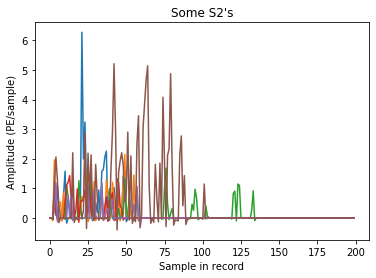

In [24]:
fig=plt.figure()
fig.patch.set_color('white')
plt.plot(peaks_true_s2['data'][:6].T)
plt.xlabel("Sample in record")
plt.ylabel("Amplitude (PE/sample)")
plt.title("Some S2's")
plt.show()

In [25]:
#truth['t_first_photon']

### S1 and S2 Comparison

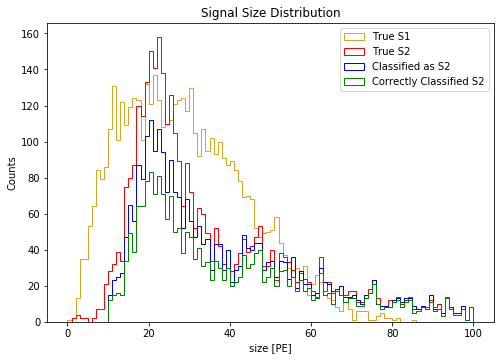

In [26]:
fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(peaks_true_s1['area'],bins=100,range=(0,100),color='goldenrod',histtype='step',label='True S1')
plt.hist(peaks_true_s2['area'],bins=100,range=(0,100),color='r',histtype='step',label='True S2')
plt.hist(peaks_classified_s2['area'],bins=100,range=(0,100),color='b',histtype='step',label='Classified as S2')
plt.hist(peaks_classified_true_s2['area'],bins=100,range=(0,100),color='g',histtype='step',label='Correctly Classified S2')
plt.legend(loc='best')
plt.xlabel('size [PE]')
plt.ylabel('Counts')
plt.title('Signal Size Distribution')
plt.show()

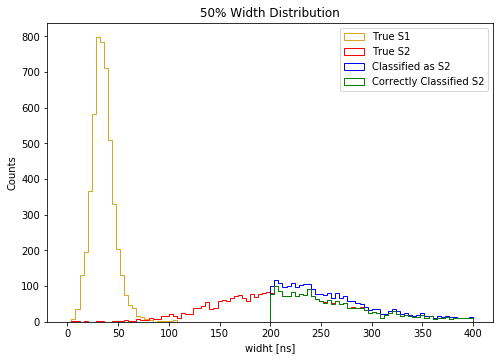

In [27]:
fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(peaks_true_s1['width'][:,5],bins=100,range=(0,400),color='goldenrod',histtype='step',label='True S1')
plt.hist(peaks_true_s2['width'][:,5],bins=100,range=(0,400),color='r',histtype='step',label='True S2')
plt.hist(peaks_classified_s2['width'][:,5],bins=100,range=(0,400),color='b',histtype='step',label='Classified as S2')
plt.hist(peaks_classified_true_s2['width'][:,5],bins=100,range=(0,400),color='g',histtype='step',label='Correctly Classified S2')
plt.legend(loc='best')
plt.xlabel('widht [ns]')
plt.ylabel('Counts')
plt.title('50% Width Distribution')
plt.show()

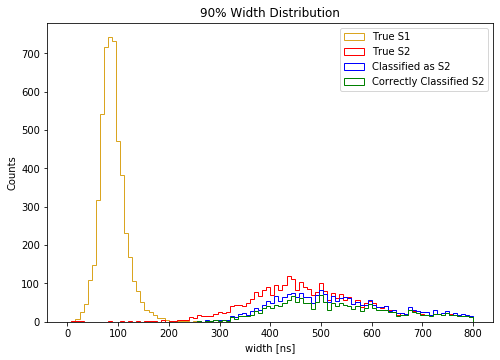

In [28]:
fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(peaks_true_s1['width'][:,9],bins=100,range=(0,800),color='goldenrod',histtype='step',label='True S1')
plt.hist(peaks_true_s2['width'][:,9],bins=100,range=(0,800),color='r',histtype='step',label='True S2')
plt.hist(peaks_classified_s2['width'][:,9],bins=100,range=(0,800),color='b',histtype='step',label='Classified as S2')
plt.hist(peaks_classified_true_s2['width'][:,9],bins=100,range=(0,800),color='g',histtype='step',label='Correctly Classified S2')
plt.legend(loc='best')
plt.xlabel('width [ns]')
plt.ylabel('Counts')
plt.title('90% Width Distribution')
plt.show()

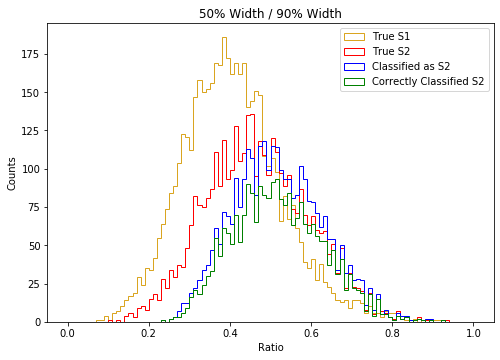

In [29]:
fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(peaks_true_s1['width'][:,5]/peaks_true_s1['width'][:,9],bins=100,range=(0,1),color='goldenrod',histtype='step',label='True S1')
plt.hist(peaks_true_s2['width'][:,5]/peaks_true_s2['width'][:,9],bins=100,range=(0,1),color='r',histtype='step',label='True S2')
plt.hist(peaks_classified_s2['width'][:,5]/peaks_classified_s2['width'][:,9],bins=100,range=(0,1),color='b',histtype='step',label='Classified as S2')
plt.hist(peaks_classified_true_s2['width'][:,5]/peaks_classified_true_s2['width'][:,9],bins=100,range=(0,1),color='g',histtype='step',label='Correctly Classified S2')
plt.legend(loc='best')
plt.xlabel('Ratio')
plt.ylabel('Counts')
plt.title('50% Width / 90% Width')
plt.show()

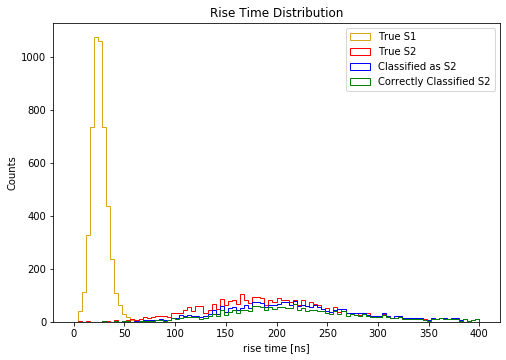

In [30]:
fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(-peaks_true_s1['area_decile_from_midpoint'][:,1],bins=100,range=(0,400),color='goldenrod',histtype='step',label='True S1')
plt.hist(-peaks_true_s2['area_decile_from_midpoint'][:,1],bins=100,range=(0,400),color='r',histtype='step',label='True S2')
plt.hist(-peaks_classified_s2['area_decile_from_midpoint'][:,1],bins=100,range=(0,400),color='b',histtype='step',label='Classified as S2')
plt.hist(-peaks_classified_true_s2['area_decile_from_midpoint'][:,1],bins=100,range=(0,400),color='g',histtype='step',label='Correctly Classified S2')
plt.legend(loc='best')
plt.xlabel('rise time [ns]')
plt.ylabel('Counts')
plt.title('Rise Time Distribution')
plt.show()

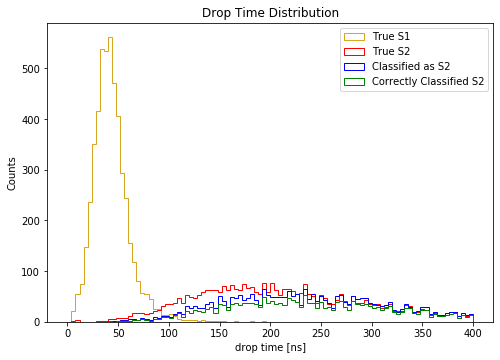

In [31]:
fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(peaks_true_s1['area_decile_from_midpoint'][:,9],bins=100,range=(0,400),color='goldenrod',histtype='step',label='True S1')
plt.hist(peaks_true_s2['area_decile_from_midpoint'][:,9],bins=100,range=(0,400),color='r',histtype='step',label='True S2')
plt.hist(peaks_classified_s2['area_decile_from_midpoint'][:,9],bins=100,range=(0,400),color='b',histtype='step',label='Classified as S2')
plt.hist(peaks_classified_true_s2['area_decile_from_midpoint'][:,9],bins=100,range=(0,400),color='g',histtype='step',label='Correctly Classified S2')
plt.legend(loc='best')
plt.xlabel('drop time [ns]')
plt.ylabel('Counts')
plt.title('Drop Time Distribution')
plt.show()

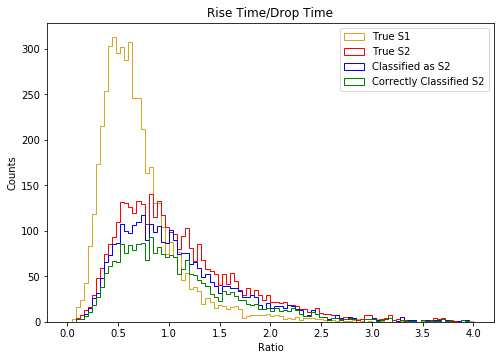

In [32]:
fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(-peaks_true_s1['area_decile_from_midpoint'][:,1]/peaks_true_s1['area_decile_from_midpoint'][:,9],bins=100,range=(0,4),color='goldenrod',histtype='step',label='True S1')
plt.hist(-peaks_true_s2['area_decile_from_midpoint'][:,1]/peaks_true_s2['area_decile_from_midpoint'][:,9],bins=100,range=(0,4),color='r',histtype='step',label='True S2')
plt.hist(-peaks_classified_s2['area_decile_from_midpoint'][:,1]/peaks_classified_s2['area_decile_from_midpoint'][:,9],bins=100,range=(0,4),color='b',histtype='step',label='Classified as S2')
plt.hist(-peaks_classified_true_s2['area_decile_from_midpoint'][:,1]/peaks_classified_true_s2['area_decile_from_midpoint'][:,9],bins=100,range=(0,4),color='g',histtype='step',label='Correctly Classified S2')
plt.legend(loc='best')
plt.xlabel('Ratio')
plt.ylabel('Counts')
plt.title('Rise Time/Drop Time')
plt.show()

In [33]:
#peaks_true_s2[peaks_true_s2['type']==2]['width'][:1][0][5]

In [34]:
#peaks_true_s2[peaks_true_s2['type']==2]['area_decile_from_midpoint'][:1]

## Training Part

In [35]:
# Import all the things needed for the BDT training
import random
import pandas
import pandas.core.common as com
from pandas.core.index import Index

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import  train_test_split

/home/zmind/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [36]:
# Prepare the arraies for training
peaks_true_s1_features_list = []
peaks_true_s2_features_list = []
peaks_afterpulse_features_list = []

for i in range(0, len(peaks_true_s1)):
    peaks_true_s1_features_list.append([peaks_true_s1['width'][i,5], peaks_true_s1['width'][i,9],
                                        peaks_true_s1['width'][i,5]/peaks_true_s1['width'][i,9], 
                                        -peaks_true_s1['area_decile_from_midpoint'][i,1], peaks_true_s1['area_decile_from_midpoint'][i,9],
                                        -peaks_true_s1['area_decile_from_midpoint'][i,1]/peaks_true_s1['area_decile_from_midpoint'][i,9]])

for i in range(0, len(peaks_true_s2)):
    peaks_true_s2_features_list.append([peaks_true_s2['width'][i,5], peaks_true_s2['width'][i,9],
                                        peaks_true_s2['width'][i,5]/peaks_true_s2['width'][i,9],
                                        -peaks_true_s2['area_decile_from_midpoint'][i,1], peaks_true_s2['area_decile_from_midpoint'][i,9],
                                        -peaks_true_s2['area_decile_from_midpoint'][i,1]/peaks_true_s2['area_decile_from_midpoint'][i,9]])

for i in range(0, len(peaks_afterpulse)):
    peaks_afterpulse_features_list.append([peaks_afterpulse['width'][i,5], peaks_afterpulse['width'][i,9], 
                                           peaks_afterpulse['width'][i,5]/peaks_afterpulse['width'][i,9],
                                           -peaks_afterpulse['area_decile_from_midpoint'][i,1], peaks_afterpulse['area_decile_from_midpoint'][i,9], 
                                           -peaks_afterpulse['area_decile_from_midpoint'][i,1]/peaks_afterpulse['area_decile_from_midpoint'][i,9]])
    
peaks_true_s1_features = np.asarray(peaks_true_s1_features_list)
peaks_true_s2_features = np.asarray(peaks_true_s2_features_list)
peaks_afterpulse_features = np.asarray(peaks_afterpulse_features_list)

In [37]:
# Combine the two 2D arrays and add one column
X = np.concatenate((peaks_true_s1_features, peaks_true_s2_features))
y = np.concatenate((np.ones(peaks_true_s1_features.shape[0]), np.zeros(peaks_true_s2_features.shape[0])))

# Randomly spliting the sample to train sample and test sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state = 1230)

# Boosted Decision tree definition
dt = DecisionTreeClassifier(max_depth=1, min_samples_leaf=5, min_samples_split=10)
bdt = AdaBoostClassifier(dt, algorithm='SAMME', n_estimators=800, learning_rate=0.5)
bdt.fit(X_train, y_train)

print('Training Finished! ')

Training Finished! 


In [38]:
# Reporting the train precision
y_predicted = bdt.predict(X_train)
print ("Training Result:")
print (classification_report(y_train, y_predicted, target_names=["S2", "S1"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_train, bdt.decision_function(X_train))))

Training Result:
              precision    recall  f1-score   support

          S2       1.00      1.00      1.00      1858
          S1       1.00      1.00      1.00      2557

    accuracy                           1.00      4415
   macro avg       1.00      1.00      1.00      4415
weighted avg       1.00      1.00      1.00      4415

Area under ROC curve: 1.0000


In [39]:
# Reporting the test precision
y_predicted = bdt.predict(X_test)
print ("Test Result")
print (classification_report(y_test, y_predicted, target_names=["S2", "S1"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, bdt.decision_function(X_test))))

Test Result
              precision    recall  f1-score   support

          S2       1.00      1.00      1.00      1976
          S1       1.00      1.00      1.00      2440

    accuracy                           1.00      4416
   macro avg       1.00      1.00      1.00      4416
weighted avg       1.00      1.00      1.00      4416

Area under ROC curve: 0.9994


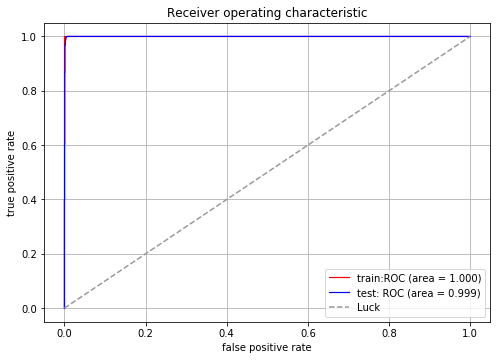

In [40]:
# Train and Test comparison of ROC curve and area under the curve
fig = plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
decisions1 = bdt.decision_function(X_train)
decisions2 = bdt.decision_function(X_test)
fpr1, tpr1, thresholds1 = roc_curve(y_train, decisions1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, decisions2)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr1, tpr1, lw=1.2, label='train:ROC (area = %0.3f)'%(roc_auc1), color="r")
plt.plot(fpr2, tpr2, lw=1.2, label='test: ROC (area = %0.3f)'%(roc_auc2), color="b")
plt.plot([0,1], [0,1], '--', color=(0.6, 0.6, 0.6), label = 'Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.grid()
plt.show()

In [41]:
# Train and Test comparison of BDT score
def compare_train_test(clf, X_train, y_train, X_test, y_test, bdt_lower_lim, bins=50):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low, high+0.05)
    
    fig = plt.figure()
    fig.patch.set_color('white')

    plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True, label='S1 (train)')
    plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True, label='S2 (train)')

    hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, density=True)
    scale = len(decisions[2])/sum(hist)
    err = np.sqrt(hist*scale)/scale

    width = (bins[1]-bins[0])
    center = (bins[:-1]+bins[1:])/2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S1 (test)')

    hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, density=True)
    scale = len(decisions[2])/sum(hist)
    err = np.sqrt(hist*scale)/scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='S2 (test)')

    plt.xlabel("BDT score")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    plt.vlines(bdt_lower_lim,0,25)
    plt.grid()
    plt.show()
    print(low)
    return None

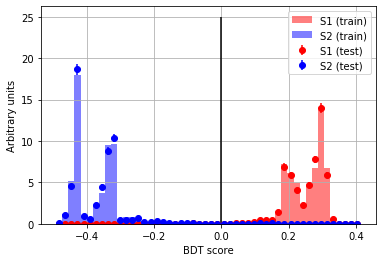

-0.4902022916919855


In [42]:
bdt_lower_lim = 0.0
compare_train_test(bdt, X_train, y_train, X_test, y_test, bdt_lower_lim)

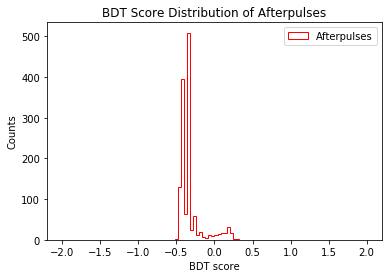

In [43]:
BDTscore_afterpulse = bdt.decision_function(peaks_afterpulse_features)
fig=plt.figure()
fig.patch.set_color('white')
plt.hist(BDTscore_afterpulse,bins=100,range=(-2,2),color='r',histtype='step',label='Afterpulses')
plt.legend(loc='best')
plt.xlabel('BDT score')
plt.ylabel('Counts')
plt.title('BDT Score Distribution of Afterpulses')
plt.show()

In [44]:
#st.show_config('peaks')

In [48]:
joblib.dump(bdt, '../BDT_model_Gap200_g2_30/BDTmodel.pkl')

['../BDT_model_Gap200_g2_30/BDTmodel.pkl']

In [46]:
#peaks.dtype

In [47]:
print("[50% Width, 90% Width, 50%/90% Ratio, Rise Time, Drop Time, Rise/Drop Ratio]")
print(bdt.feature_importances_)

[50% Width, 90% Width, 50%/90% Ratio, Rise Time, Drop Time, Rise/Drop Ratio]
[0.0833786  0.19694919 0.16509112 0.28930917 0.09519157 0.17008034]
